In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/exchange_rate.csv')

# Display the first few rows
print(df.head())


               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849


In [2]:
df.columns


Index(['date', 'Ex_rate'], dtype='object')

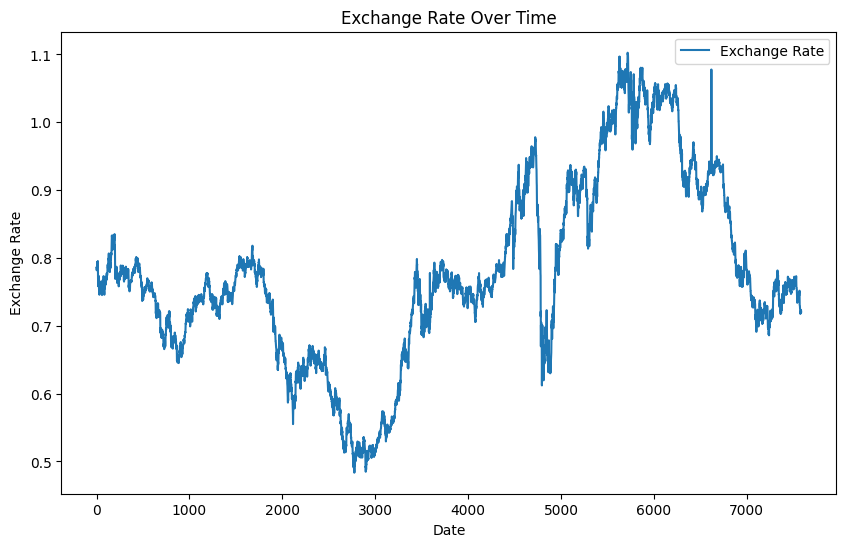

In [3]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [4]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values by forward filling
df.fillna(method='ffill', inplace=True)

# Confirm no more missing values
print(df.isnull().sum())


date       0
Ex_rate    0
dtype: int64
date       0
Ex_rate    0
dtype: int64


In [5]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))  # Example order, adjust based on ACF/PACF
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 26 Jun 2024   AIC                         -56102.322
Time:                        05:56:25   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

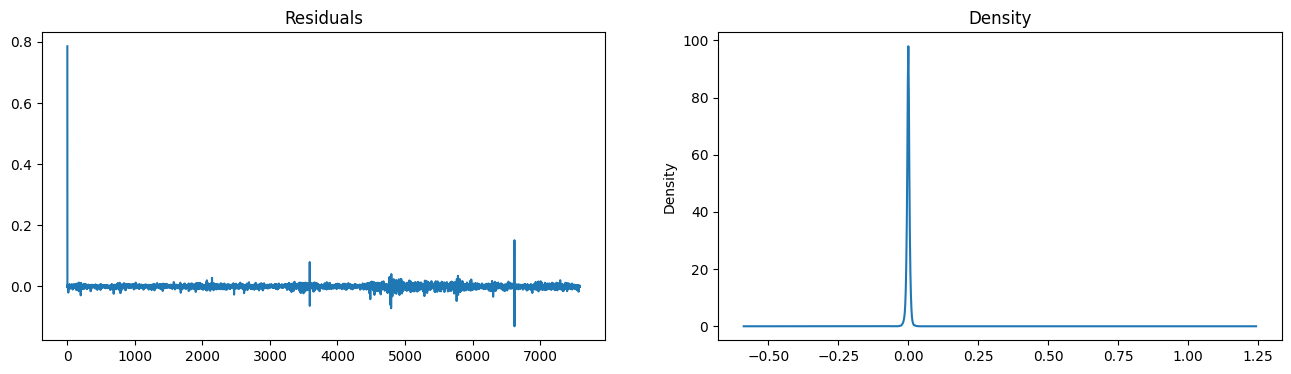

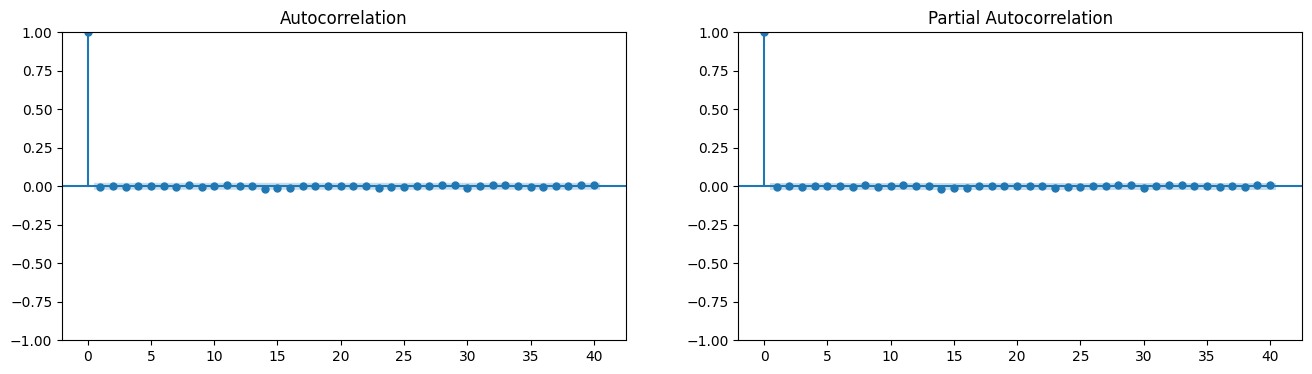

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the missing functions


# Plot residuals
residuals = model_fit.resid
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Check for patterns in residuals
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals, lags=40, ax=ax[0]) # Now you can use plot_acf and plot_pacf
plot_pacf(residuals, lags=40, ax=ax[1])
plt.show()

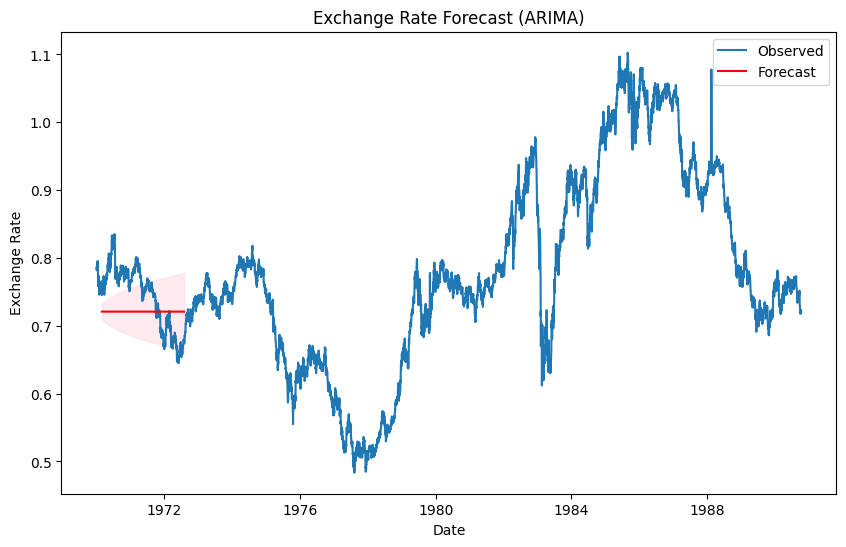

In [12]:
# Forecasting with ARIMA
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)

# Generate forecast index (ensure it matches the length of forecast)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Ex_rate'], label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Exchange Rate Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Fit the Exponential Smoothing model
model_es = ExponentialSmoothing(df['Ex_rate'], seasonal='add', seasonal_periods=12)
model_es_fit = model_es.fit()

# Print summary of the model
print(model_es_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77628.560
Trend:                             None   BIC                         -77531.480
Seasonal:                      Additive   AICC                        -77628.488
Seasonal Periods:                    12   Date:                 Wed, 26 Jun 2024
Box-Cox:                          False   Time:                         06:17:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698356                alpha                 True
smoothing_seasonal       

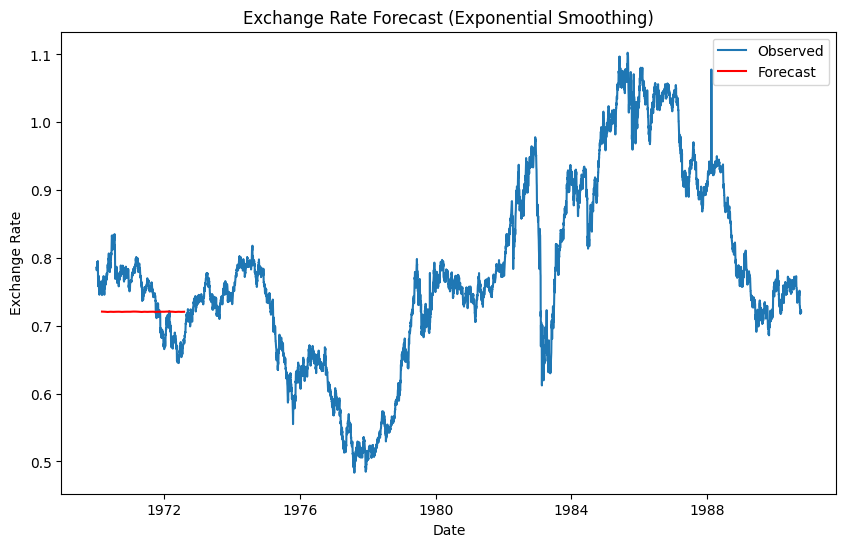

In [16]:
# Forecasting with Exponential Smoothing
forecast_es = model_es_fit.forecast(steps=forecast_steps)

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Ex_rate'], label='Observed')
plt.plot(forecast_index, forecast_es, label='Forecast', color='red')
plt.title('Exchange Rate Forecast (Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Calculate error metrics for ARIMA
forecast_values_arima = forecast.predicted_mean
actual_values = df['Ex_rate'][-forecast_steps:]
mae_arima = mean_absolute_error(actual_values, forecast_values_arima)
rmse_arima = np.sqrt(mean_squared_error(actual_values, forecast_values_arima))
mape_arima = np.mean(np.abs(forecast_values_arima - actual_values)/np.abs(actual_values))*100

# Calculate error metrics for Exponential Smoothing
forecast_values_es = forecast_es
mae_es = mean_absolute_error(actual_values, forecast_values_es)
rmse_es = np.sqrt(mean_squared_error(actual_values, forecast_values_es))
mape_es = np.mean(np.abs(forecast_values_es - actual_values)/np.abs(actual_values))*100

print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}')
print(f'Exponential Smoothing MAE: {mae_es}, RMSE: {rmse_es}, MAPE: {mape_es}')


ARIMA MAE: 0.012724006489305202, RMSE: 0.016982710912755217, MAPE: nan
Exponential Smoothing MAE: 0.012893873162132911, RMSE: 0.017130676033911125, MAPE: nan


In [21]:
# Display the comparison
comparison = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing'],
    'MAE': [mae_arima, mae_es],
    'RMSE': [rmse_arima, rmse_es],
    'MAPE': [mape_arima, mape_es]
})

print(comparison)

                   Model       MAE      RMSE  MAPE
0                  ARIMA  0.012724  0.016983   NaN
1  Exponential Smoothing  0.012894  0.017131   NaN


From the comparision we can see Arima and exponential smoothing shows approx same accuracy
